#### Формулы, используемые в дальнейшем
##### Формулы *Forward Propagation*
Для первого слоя:
    $$Z^{[1]} = XW^{[1]T} + b^{[1]}, $$ где $^{[1]}$ - номер слоя, X (<кол-во точек>x<кол-во характеристик>) - матрица исходных данных, $W^T$ (<кол-во характеристик>x<кол-во нейронов>) - матрица весов, b (<кол-во точек>x<кол-во нейронов>) - матрица значений смещения, Z (<кол-во точек>x<кол-во нейронов>) - линейный выход нейронов.
    $$A^{[1]} = \sigma^{[1]}(Z^{[1]}), $$ где A (<кол-во точек>x<кол-во нейронов>) - нелиненый выход нейронов, $\sigma$ - функция активации
 
Для последующих слоёв:
    $$Z^{[i]} = A^{[i-1]}W^{[i]T} + b^{[i]},$$ $A^{[i-1]}$ (<кол-во точек>x<кол-во нейронов i-1 слоя>), $W^T$ (<кол-во нейронов i-1 слоя>x<кол-во нейронов i слоя>), b (<кол-во точек>x<кол-во нейронов i слоя>)
    $$A^{[i]} = \sigma^{[i]}(Z^{[i]}) $$
    
Для последнего слоя:
    $$Z^{[i]} = A^{[i-1]}W^{[i]T} + b^{[i]},$$ где $W^T$ (<кол-во нейронов i-1 слоя>x<кол-во точек>) - матрица весов последнего нейрона, b (<количество точек>x1) - параметр смещения
    $$\hat{y} = \sigma^{[i]}(Z^{[i]}), $$ где $\hat{y}$ (<количество точек>x1)- предсказанные значения для каждой точки
##### *Bacward Propagation*
Для последнего слоя:
    $$dZ^{[i]} = ({\partial L \over \partial Z})^{[i]} = {\partial L \over \partial \hat{y}}*({\partial \hat{y} \over \partial Z})^{[i]} = dL * df^{[i]},$$ где f - функция активации
    $$dW{[i]} = {\partial L \over \partial W} = ({\partial L \over \partial Z^{[i]}})^T \cdot {\partial Z^{[i]} \over \partial W^{[i]}} = dZ^{[i]T} \cdot A^{[i-1]} $$
    $$db^{[i]} = {\partial L \over \partial b} = ({\partial L \over \partial Z^{[i]}})^T \cdot {\partial Z^{[i]} \over \partial b^{[i]}} = dZ^{[i]T} \cdot \mathbf{1}$$
Для последующих слоёв:
    $$dZ^{[i]} = {\partial L \over \partial Z^{[i]}} = {\partial L \over \partial A^{[i]}}*{\partial A^{[i]} \over \partial Z^{[i]}} = ({\partial L \over \partial Z^{[i+1]}} \cdot W^{[i+1]})*{df^{[i]}}$$
    $$dW{[i]} = ({\partial L \over \partial Z^{[i]}})^T \cdot {\partial Z^{[i]} \over \partial W^{[i]}} = dZ^{[i]T} \cdot A^{[i-1]} $$
    $$db^{[i]} = ({\partial L \over \partial Z^{[i]}})^T \cdot {\partial Z^{[i]} \over \partial b^{[i]}} = dZ^{[i]T} \cdot \mathbf{1}$$
Для первого слоя:
    $$dZ^{[1]} = {\partial L \over \partial Z^{[1]}} = {\partial L \over \partial A^{[1]}}*{\partial A^{[1]} \over \partial Z^{[1]}} = ({\partial L \over \partial Z^{[2]}} \cdot W^{[2]})*{df^{[1]}}$$
    $$dW{[1]} = ({\partial L \over \partial Z^{[1]}})^T \cdot {\partial Z^{[1]} \over \partial W^{[1]}} = dZ^{[1]T} \cdot X $$
    $$db^{[1]} = ({\partial L \over \partial Z^{[1]}})^T \cdot {\partial Z^{[1]} \over \partial b^{[1]}} = dZ^{[1]T} \cdot \mathbf{1}$$

In [93]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#from scipy.constants import point
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score

##### Датасет для обучения нейронной сети

In [94]:
 def load_planar_dataset(m=400):
        np.random.seed(1)
        N = int(m/2)  # number of points per class
        D = 2  # dimensionality
        X = np.zeros((m,D))  # data matrix where each row is a single example
        Y = np.zeros((m,1), dtype='uint8')  # labels vector (0 for red, 1 for blue)
        a = 4  # maximum ray of the flower

        for j in range(2):
            ix = range(N*j,N*(j+1))
            t = np.linspace(j*3.12,(j+1)*3.12,N) + np.random.randn(N)*0.2  # theta
            r = a*np.sin(4*t) + np.random.randn(N)*0.2  # radius
            X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
            Y[ix] = j
    
        return X, Y  # X - Coordinates, Y - Color of the points

##### Графическое изображение полученного датасета

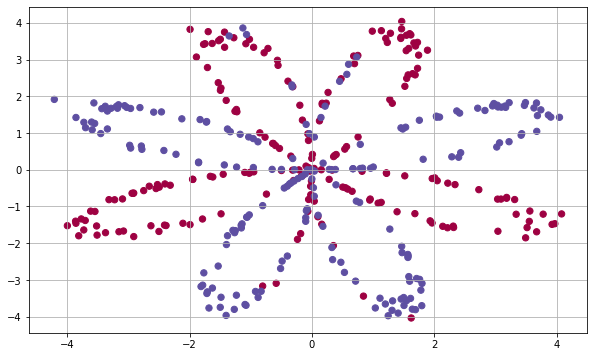

In [95]:
X, Y = load_planar_dataset(400)  #загружаем датасет
plt.figure(figsize=(10,6))
plt.grid()
plt.scatter(X[:,0], X[:,1], c=Y[:,0], s=40, cmap=plt.cm.Spectral);

##### Функция для графического отображения работы нейросети

In [96]:
def plot_decision_boundary(model, X, y):
        # Set min and max values and give it some padding
        X = X.T
        x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
        y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
        h = 0.01
        # Generate a grid of points with distance h between them
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        # Predict the function value for the whole grid
        Z = model(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        # Plot the contour and training examples
        plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
        plt.ylabel('x2')
        plt.xlabel('x1')
        plt.scatter(X[0, :], X[1, :], c=y, cmap=plt.cm.Spectral)
        plt.show()

##### Класс, хранящий параметры модели

In [97]:
class MultiLayersNN:
    def __init__(self, n_input, n_hidden, activation_funs, activation_backward):
        self.layers = len(activation_funs)
        self.params = {}
        self.gradients = {}
        self.activation_funs = activation_funs
        self.activation_backward = activation_backward
        self.cache = {}
        assert (len(activation_funs) == len(activation_backward) == len(n_hidden)+1), "Number of layers must be equal number of activation_funs and activation_backward!"

        self._initialize_params(n_input, n_hidden)

    def _initialize_params(self, n_input, n_hidden):
        self.params["w1"] = np.random.randn(n_hidden[0], n_input)
        self.params["b1"] = np.zeros(n_hidden[0])
        self.cache["a1"] = None
        self.cache["z1"] = None
        self.cache["X"] = None
        
        for i in range(1, self.layers - 1):
            self.params["w" + str(i + 1)] = np.random.randn(n_hidden[i], n_hidden[i-1])
            self.params["b" + str(i + 1)] = np.zeros(n_hidden[i])
            self.cache["a" + str(i + 1)] = None
            self.cache["z" + str(i + 1)] = None
        
        self.params["w" + str(self.layers)] = np.random.randn(1, n_hidden[self.layers - 2])
        self.params["b" + str(self.layers)] = np.zeros(1,)
        self.cache["a" + str(self.layers)] = None
        self.cache["z" + str(self.layers)] = None

        for key in self.params.keys():
            self.gradients['d' + key] = np.zeros_like(self.params[key])

    #Для одного слоя
    def layer_forward(self, a_previous, i):
        z = a_previous @ self.params["w" + str(i)].T + self.params["b" + str(i)]
        a_current = self.activation_funs[i - 1](z)
        self.cache["a" + str(i)] = a_current
        self.cache["z" + str(i)] = z
        return a_current
        pass
    
    #Для всех слоёв
    def forward(self, X):
        self.cache['X'] = X
        a_current = X
        for i in range(1, self.layers + 1):
            a_current = self.layer_forward(a_current, i)
        return a_current
    
    def __call__(self, X):
        return self.forward(X)

#Backward Propagation
    
    #Для одного слоя
    def layer_backward(self, dz, i):
        z = self.cache["z" + str(i)]
        if i == 1:
            a_previous = self.cache["X"]
        if i != 1:    
            a_previous = self.cache["a" + str(i-1)]
        dz_previous = (dz @ self.params["w" + str(i + 1)]) * self.activation_backward[i](z)
        dw_previous = dz_previous.T @ a_previous
        db_previous = dz_previous.T @ np.ones(a_previous.shape[0])
        self.gradients["dw" + str(i)] = dw_previous
        self.gradients["db" + str(i)] = db_previous
        return dz_previous, dw_previous, db_previous

    def backward(self, dL):
        X = self.cache['X']
        z = self.cache["z" + str(self.layers)]
        a = self.cache["a" + str(self.layers)]
        a_previous = self.cache["a" + str(self.layers - 1)]
        dz = dw = db = None
        
        dz = dL * self.activation_backward[0](z)
        dw = dL.T @ a_previous
        db = dL.T @ np.ones((z.shape[0]))
        self.gradients["dw" + str(self.layers)] = dw
        self.gradients["db" + str(self.layers)] = db

        for i in range(self.layers - 1, 0, -1):
            dz, dw, db = self.layer_backward(dz, i)

    def summary(self):
        num_layers = len(self.params)//2
        for i in range(1, num_layers + 1):
            w_ind, b_ind = f'w{i}', f'b{i}'
            print(f"Layer_{i}\t weights shape: {self.params[w_ind].shape}\t bias shape: {self.params[b_ind].shape}")

##### Класс, хранящий функции для обновления параметров модели

In [98]:
class Optimizer:
    def __init__(self, regression_class, lr=1e-2):
        self.model = regression_class
        self.lr = lr
        
    def step(self):
        new_params = {
            k: None for k in self.model.params
        }
        params = self.model.params
        grads = self.model.gradients
        
        for key in self.model.params.keys():
            new_params[key] = params[key] - self.lr * grads["d"+key]
        self.model.params = new_params

    def zero_grad(self):
        for key in self.model.gradients.keys():
            self.model.gradients[key] = np.zeros_like(self.model.gradients[key])

##### Класс для расчёта потерь и вычисления градиентов

In [99]:
class Loss:
    def __init__(self, model, loss_fn, loss_fn_bw):
        self.model = model
        self.loss_fn = loss_fn
        self.loss_fn_bw = loss_fn_bw
        self.dL = None
        self.a = None
        self.y = None
    
    
    def __call__(self, a, y):
        self.a = a
        self.y = y
        return self.loss_fn(a, y)
    
    
    def forward(self, a, y):
        return self.__call__(a, y)
    
    
    def backward(self, **params):
        assert (self.a is not None) and (self.y is not None), "loss.forward() must be called first!"
        self.dL = self.loss_fn_bw(self.a, self.y)
        self.model.backward(self.dL, **params)
            
def binary_crossentropy(a, y, eps=1e-5):
    return -( y*np.log(eps+a) + (1. - y)*np.log(eps+1. - a)).mean()

def binary_crossentropy_bw(a, y, eps=1e-5):
    return -1./len(a)*((y-a)/ (eps+ a*(1.-a)))

##### Основное тело программы

In [100]:
X, y = load_planar_dataset(m=1000)

#Деление на train и test
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True)

#Количество нейронов в скрытых слоях
n_hidden = [5, 4, 3]

#Функции активации и их производные
activation_funs = [lambda x: np.tanh(x), lambda x: np.tanh(x), lambda x: np.tanh(x), lambda x: 1./(np.exp(-x)+1.)]
activation_backward = [lambda x: 1 - np.tanh(x)**2, lambda x: 1 - np.tanh(x)**2, lambda x: 1 - np.tanh(x)**2, lambda x: 1./(np.exp(-x)+1.)*(1 - 1./(np.exp(-x)+1.))]

model = MultiLayersNN(n_input=2, n_hidden=n_hidden, activation_funs=activation_funs, activation_backward = activation_backward)
optimizer = Optimizer(model, lr=1e-2)
loss = Loss(model, binary_crossentropy, binary_crossentropy_bw)
model.summary()

Layer_1	 weights shape: (5, 2)	 bias shape: (5,)
Layer_2	 weights shape: (4, 5)	 bias shape: (4,)
Layer_3	 weights shape: (3, 4)	 bias shape: (3,)
Layer_4	 weights shape: (1, 3)	 bias shape: (1,)


In [101]:
num_epochs = 15000
epoches = [i for i in range(1, num_epochs + 1)]
sum = 0;
for i in range(num_epochs):
    a = model(X_train)
    l = loss(a, y_train)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    if (i % 400 == 0):
        a_val = model(X_test)
        print("Epoch %d/%d\t Loss: %.3f"%(i, num_epochs, l), end='\t')
        print("Accuracy: %.3f"%(accuracy_score(y_train, a>0.5)), end='\t')
        print("Val_loss: %.3f"%(loss(a_val, y_test)), end='\t')
        print("Val_accuracy: %.3f"%(accuracy_score(y_test, a_val>0.5)))

Epoch 0/15000	 Loss: 0.807	Accuracy: 0.513	Val_loss: 0.799	Val_accuracy: 0.512
Epoch 400/15000	 Loss: 0.566	Accuracy: 0.861	Val_loss: 0.580	Val_accuracy: 0.812
Epoch 800/15000	 Loss: 0.419	Accuracy: 0.891	Val_loss: 0.435	Val_accuracy: 0.876
Epoch 1200/15000	 Loss: 0.343	Accuracy: 0.896	Val_loss: 0.358	Val_accuracy: 0.892
Epoch 1600/15000	 Loss: 0.300	Accuracy: 0.905	Val_loss: 0.313	Val_accuracy: 0.900
Epoch 2000/15000	 Loss: 0.277	Accuracy: 0.915	Val_loss: 0.288	Val_accuracy: 0.908
Epoch 2400/15000	 Loss: 0.267	Accuracy: 0.912	Val_loss: 0.280	Val_accuracy: 0.892
Epoch 2800/15000	 Loss: 0.258	Accuracy: 0.915	Val_loss: 0.267	Val_accuracy: 0.904
Epoch 3200/15000	 Loss: 0.249	Accuracy: 0.913	Val_loss: 0.251	Val_accuracy: 0.924
Epoch 3600/15000	 Loss: 0.244	Accuracy: 0.919	Val_loss: 0.242	Val_accuracy: 0.932
Epoch 4000/15000	 Loss: 0.239	Accuracy: 0.917	Val_loss: 0.237	Val_accuracy: 0.928
Epoch 4400/15000	 Loss: 0.236	Accuracy: 0.916	Val_loss: 0.233	Val_accuracy: 0.932
Epoch 4800/15000	 Los

Decision Boundary


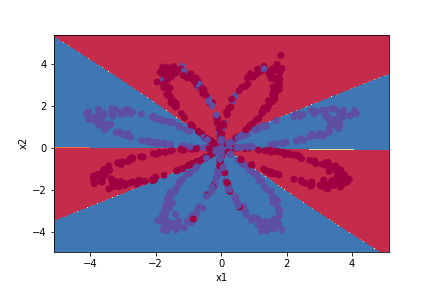

<Figure size 432x288 with 0 Axes>

In [102]:
print("Decision Boundary")
plot_decision_boundary(lambda x: model(x)>0.5, X_train, y_train)